# **Kontrolna tačka 2 – Analiza podataka, pretprocesiranje i baseline algoritmi**

# 1. Uvod


Cilj ove kontrolne tačke je analiza dodeljenog skupa podataka za detekciju automobila,
sprovođenje osnovnog pretprocesiranja i implementacija jednostavnog baseline modela.
Ova faza predstavlja vezu između teorijske osnove obuhvaćene u CP1 i praktične primene
algoritama detekcije objekata na realnim podacima.




# 2. Analiza dataseta

Učitavanje dataseta i prikaz strukture.
Dataset je organizovan u sledeću strukturu:

- training_images – 175 slika za treniranje modela
- testing_images – 1001 slika za testiranje
- train_solution_bounding_boxes.csv – anotacije objekata (bounding boxes)
- sample_submission.csv – primer formata za predikcije

Format slika: .jpg
Veličina slika: 676x380(width x height)

Anotacije su date u CSV formatu sa koordinatama graničnih okvira:
(x_min, y_min, x_max, y_max). Dataset sadrži jednu klasu – automobil.




In [3]:
%matplotlib inline

import os
import zipfile
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

data_dir = '/content/drive/MyDrive/Car_Object_Detection'

print("Putanja dataseta:", data_dir)
for root, dirs, files in os.walk(data_dir):
    level = root.replace(data_dir, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    for f in files[:5]:
        print(f"{indent}    {f}")


Putanja dataseta: /content/drive/MyDrive/Car_Object_Detection
Car_Object_Detection/
    data/
        sample_submission.csv
        train_solution_bounding_boxes (1).csv
        training_images/
            vid_4_10540.jpg
            vid_4_11280.jpg
            vid_4_11180.jpg
            vid_4_10500.jpg
            vid_4_12600.jpg
        testing_images/
            vid_5_27660.jpg
            vid_5_28520.jpg
            vid_5_27840.jpg
            vid_5_28340.jpg
            vid_5_28180.jpg


Učitavanje anotacija i osnovna analiza

In [4]:
import pandas as pd
import os


annotations = pd.read_csv(
    os.path.join(data_dir, 'data', 'train_solution_bounding_boxes (1).csv')
)

# Analiza veličina bounding box-ova
annotations['bbox_width'] = annotations['xmax'] - annotations['xmin']
annotations['bbox_height'] = annotations['ymax'] - annotations['ymin']
annotations['bbox_area'] = annotations['bbox_width'] * annotations['bbox_height']

print(f"\nStatistike bounding box-ova:")
print(f"Prosečna širina: {annotations['bbox_width'].mean():.2f}px")
print(f"Prosečna visina: {annotations['bbox_height'].mean():.2f}px")
print(f"Prosečna površina: {annotations['bbox_area'].mean():.2f}px²")

print("Broj anotacija:", len(annotations))
print("Broj unikatnih slika:", annotations['image'].nunique())
annotations.head()




Statistike bounding box-ova:
Prosečna širina: 101.94px
Prosečna visina: 44.98px
Prosečna površina: 5064.24px²
Broj anotacija: 559
Broj unikatnih slika: 355


image        xmin        ymin        xmax        ymax  \
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547   
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180   
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180   
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575   
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422   

   bbox_width  bbox_height    bbox_area  
0   46.468886    36.190476  1681.731098  
1  105.166425    49.395109  5194.707092  
2  122.775687    59.665380  7325.458007  
3  133.536903    59.176319  7902.222397  
4  115.927641    51.840412  6009.736653

# 3.Vizualizacija

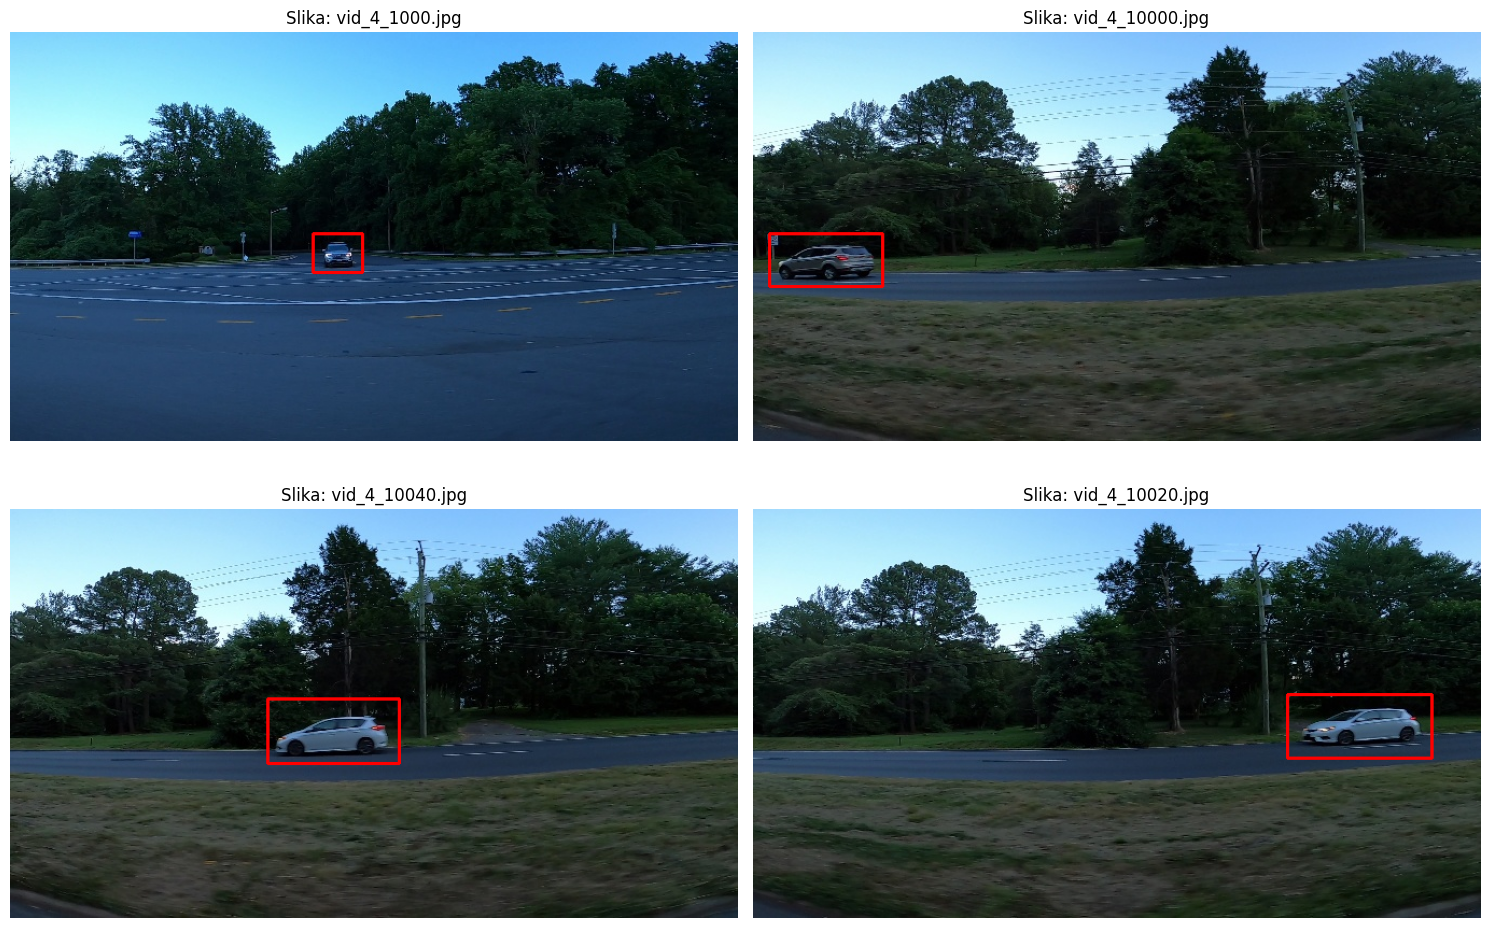

In [14]:
unique_images = annotations['image'].unique()[:4]

plt.figure(figsize=(15, 10))

for i, img_name in enumerate(unique_images):
    img_path = os.path.join(data_dir, 'data', 'training_images', img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Izdvajanje svih okvira za trenutnu sliku
    img_boxes = annotations[annotations['image'] == img_name]

    for _, row in img_boxes.iterrows():
        cv2.rectangle(
            img,
            (int(row['xmin']), int(row['ymin'])),
            (int(row['xmax']), int(row['ymax'])),
            (255, 0, 0),
            2
        )

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"Slika: {img_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Vizualizacija potvrđuje da su anotacije korektno mapirane na slike.
Primećuje se značajna varijacija u veličini automobila, što predstavlja
izazov za detekcione modele, posebno kod objekata udaljenih od kamere.


U ovom koraku smo izračunali broj slika na kojima se nalazi automobil(355) i broj slika na kojima se ne nalazi automobil(646).

In [6]:
import os
# Putanja do foldera sa trening slikama
train_images_dir = os.path.join(data_dir,'data', 'training_images')

# Sve slike u training_images folderu
all_images = set(os.listdir(train_images_dir))

# Slike koje imaju anotacije (znači imaju automobil)
images_with_cars = set(annotations['image'].unique())

# Slike bez automobila
images_without_cars = all_images - images_with_cars

print("Ukupan broj trening slika:", len(all_images))
print("Broj slika sa automobilima:", len(images_with_cars))
print("Broj slika bez automobila:", len(images_without_cars))

Ukupan broj trening slika: 1001
Broj slika sa automobilima: 355
Broj slika bez automobila: 646


**BAR CHART**
Prikaz raspodele slika sa automobilom i slika bez automobila

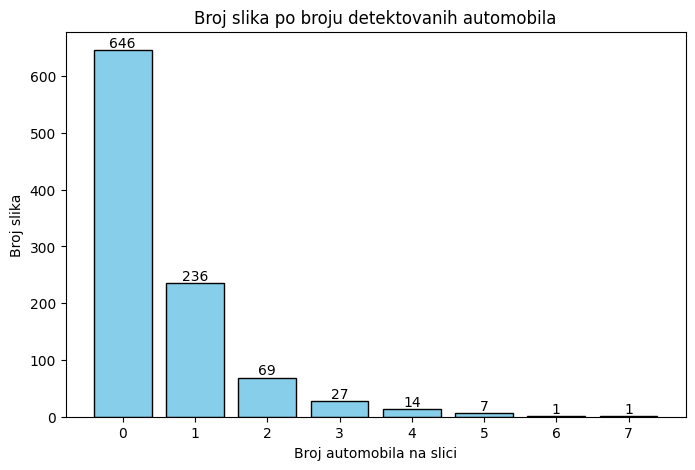

In [15]:
# Brojanje automobila po slici iz anotacija
car_counts_per_image = annotations.groupby('image').size()

# Dodavanje slika koje nemaju automobile (count = 0)
zero_car_counts = pd.Series(0, index=list(images_without_cars))

# Spajanje svih podataka
all_counts = pd.concat([car_counts_per_image, zero_car_counts])

# Frekvencija pojavljivanja određenog broja automobila
distribution = all_counts.value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(distribution.index.astype(str), distribution.values, color='skyblue', edgecolor='black')

plt.title('Broj slika po broju detektovanih automobila')
plt.xlabel('Broj automobila na slici')
plt.ylabel('Broj slika')

# Dodavanje vrednosti iznad barova
for i, v in enumerate(distribution.values):
    plt.text(i, v + 5, str(v), ha='center')

plt.show()

**PIE CHART**

Prikaz procentualne raspodele slika sa automobilom i slika bez automobila

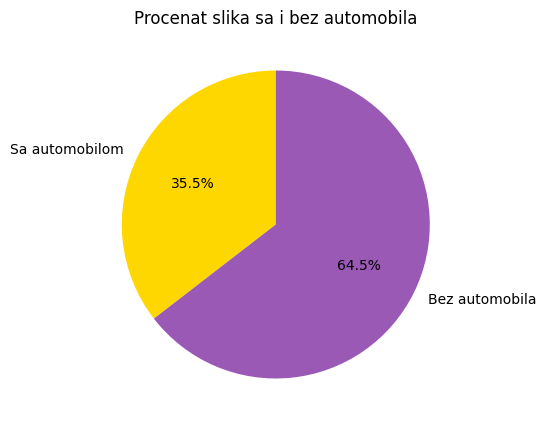

In [13]:

labels = ['Sa automobilom', 'Bez automobila']
values = [len(images_with_cars), len(images_without_cars)]
colors = ['#FFD700', '#9b59b6']
plt.figure(figsize=(5,5))
plt.pie(
    values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
plt.title('Procenat slika sa i bez automobila')
plt.show()

# 4. Pretprocesiranje
Implementirana je funkcija za augmentaciju podataka koristeći biblioteku Albumentations, koja omogućava transformaciju slika uz automatsko prilagođavanje pripadajućih graničnih okvira (bounding boxes). Primenjene transformacije uključuju horizontalno preslikavanje, promenu osvetljenja i kontrasta, kao i blago zamućenje i rotaciju.

Izvršeno je oversamplovanje kako bi se dataset proširio na ukupno 5.000 slika, čime je postignut balans između klasa. Obe klase (slike sa i bez automobila) dopunjene su do broja od 2.500 uzoraka. Na kraju je izvršena vizualizacija nasumičnih augmentovanih primera radi verifikacije ispravnosti primenjenih transformacija i pozicija graničnih okvira.

## Implementacija augmentacione funkcije




In [16]:
!pip install -U albumentations
import albumentations as A
print("Albumentations installed and imported.")

Albumentations installed and imported.


Ovim kodom je kreiran automatizovani proces za transformaciju slika koji istovremeno prilagođava pozicije graničnih okvira kako bi ostali precizno usklađeni sa objektima



In [17]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Blur(blur_limit=3, p=0.1),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

def augment_image(image, bboxes):
    labels = ['car'] * len(bboxes)
    transformed = transform(image=image, bboxes=bboxes, class_labels=labels)
    return transformed['image'], transformed['bboxes']

sample_img_name = annotations['image'].iloc[0]
sample_path = os.path.join(data_dir, 'data', 'training_images', sample_img_name)
sample_img = cv2.imread(sample_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

sample_bboxes = annotations[annotations['image'] == sample_img_name][['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()

aug_img, aug_bboxes = augment_image(sample_img, sample_bboxes)

print(f"Original Bboxes: {sample_bboxes}")
print(f"Augmented Bboxes: {aug_bboxes}")
print(f"Augmented image shape: {aug_img.shape}")

Original Bboxes: [[281.2590449, 187.0350708, 327.7279305, 223.225547]]
Augmented Bboxes: [[374.5077923869399, 204.03968441551567, 427.305639755072, 251.19488780724447]]
Augmented image shape: (380, 676, 3)


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


**Balansiranje**
Ovde je izvršeno balansiranje dataseta. Generisano je ukupno 3999 novih slika (2145 sa automobilima i 1854 bez njih), čime smo, uz postojeće originalne slike, postigli ciljani balans od tačno 2500 uzoraka po klasi. Dataset je sada spreman za treniranje modela bez rizika od pristrasnosti prema klasi bez automobila.



In [20]:
import random
import os
import cv2

# Liste slika po klasama
list_with_cars = list(images_with_cars)
list_without_cars = list(images_without_cars)

target_per_class = 2500
augmented_data = []

# 1. Balansiranje klase SA AUTOMOBILIMA (Oversampling do 2500)
num_to_aug_pos = target_per_class - len(list_with_cars)
print(f"Generišem {num_to_aug_pos} augmentovanih slika sa automobilima...")

for i in range(num_to_aug_pos):
    img_name = random.choice(list_with_cars)
    img_path = os.path.join(data_dir, 'data', 'training_images', img_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bboxes = annotations[annotations['image'] == img_name][['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()

    aug_img, aug_boxes = augment_image(image, bboxes)
    augmented_data.append({
        'image_name': f"aug_pos_{i}_{img_name}",
        'image_data': aug_img,
        'bboxes': aug_boxes,
        'class': 'positive'
    })

# 2. Balansiranje klase BEZ AUTOMOBILA (Oversampling do 2500)
num_to_aug_neg = target_per_class - len(list_without_cars)
print(f"Generišem {num_to_aug_neg} augmentovanih slika bez automobila...")

for i in range(num_to_aug_neg):
    img_name = random.choice(list_without_cars)
    img_path = os.path.join(data_dir, 'data', 'training_images', img_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Za slike bez automobila, bboxes je prazna lista
    aug_img, _ = augment_image(image, [])
    augmented_data.append({
        'image_name': f"aug_neg_{i}_{img_name}",
        'image_data': aug_img,
        'bboxes': [],
        'class': 'negative'
    })

print(f"\nProces završen!")
print(f"Ukupno novih slika: {len(augmented_data)}")
print(f"Finalni balans: {target_per_class} pozitivnih i {target_per_class} negativnih uzoraka.")

Generišem 2145 augmentovanih slika sa automobilima...
Generišem 1854 augmentovanih slika bez automobila...

Proces završen!
Ukupno novih slika: 3999
Finalni balans: 2500 pozitivnih i 2500 negativnih uzoraka.




Vizualizacija nekoliko nasumičnih augmentovanih slika



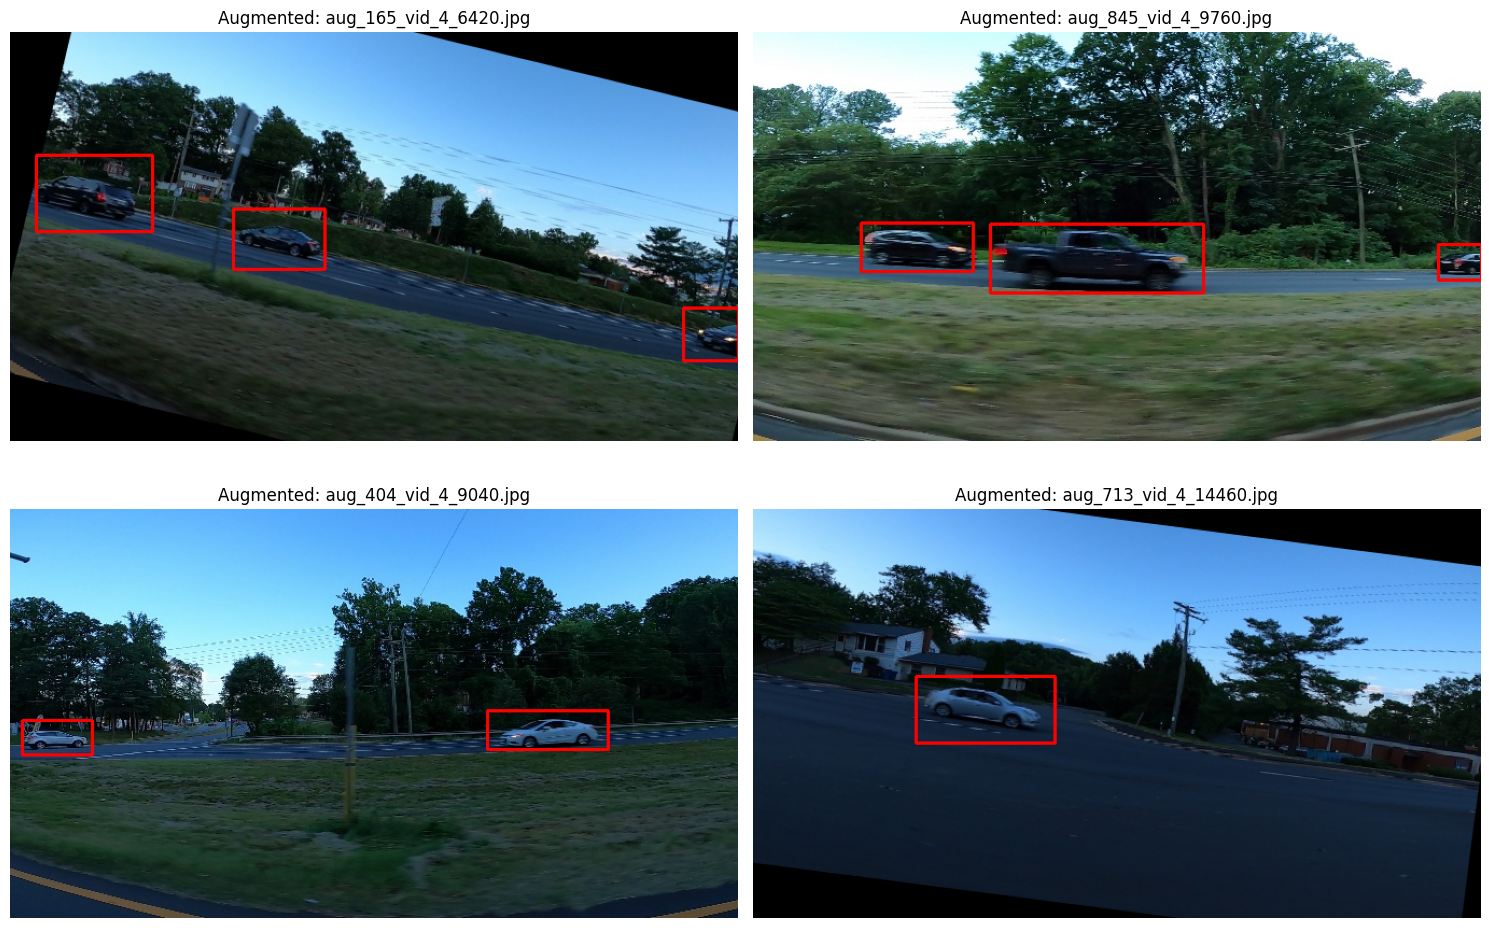

In [19]:
plt.figure(figsize=(15, 10))
sample_aug_indices = random.sample(range(len(augmented_data)), 4)

for i, idx in enumerate(sample_aug_indices):
    sample = augmented_data[idx]
    img = sample['image_data'].copy()
    bboxes = sample['bboxes']

    for bbox in bboxes:
        xmin, ymin, xmax, ymax = map(int, bbox)
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"Augmented: {sample['image_name']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Vizuelizacija augmentovanih primera


Prikaz nekoliko nasumičnih slika nakon augmentacije kako bismo potvrdili da su transformacije i okviri ispravno primenjeni.


# 5. Baseline model i rezultati

Dataset je pripremljen za binarnu klasifikaciju objedinjavanjem originalnih slika i 3.999 augmentovanih uzoraka u jedinstvene nizove slika i labela. Za potrebe klasifikacije korišćeno je 355 originalnih slika sa automobilima i 646 slika bez automobila, zajedno sa generisanim augmentovanim podacima.
Sve slike su skalirane na dimenzije (128, 128), vrednosti piksela su normalizovane na opseg [0, 1], a podaci su podeljeni na trening i test setove. Nakon toga, implementirana je osnovna konvolutivna neuronska mreža (CNN) pomoću TensorFlow/Keras biblioteke, koja je trenirana da razlikuje slike sa i bez automobila.

## Priprema podataka za detekciju


U ovoj ćeliji se formira konačni dataset objedinjavanjem originalnih i augmentovanih slika, pri čemu su sve slike skalirane na dimenzije (128, 128) i normalizovane na opseg [0, 1]. Podaci su zatim konvertovani u NumPy nizove i podeljeni na trening i test set (u odnosu 80:20), uz korišćenje stratifikacije kako bi se očuvao balans klasa u oba skupa.


In [22]:
X = []
y = []
target_size = (128, 128)

print("Processing original images...")
for img_name in all_images:
    img_path = os.path.join(data_dir, 'data', 'training_images', img_name)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        X.append(img / 255.0)
        y.append(1 if img_name in images_with_cars else 0)

print("Processing augmented images...")
for item in augmented_data:
    img = cv2.resize(item['image_data'], target_size)
    X.append(img / 255.0)
    y.append(1 if item['class'] == 'positive' else 0)

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Data preparation complete.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Class balance in y_train: {np.bincount(y_train)}")

Processing original images...
Processing augmented images...
Data preparation complete.
X_train shape: (4000, 128, 128, 3), y_train shape: (4000,)
X_test shape: (1000, 128, 128, 3), y_test shape: (1000,)
Class balance in y_train: [2000 2000]


## Implementacija baseline modela za detekciju


Kreiranje i obuka jednostavnog CNN modela za binarnu klasifikaciju slika (automobil vs. bez automobila).


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 1. Definisanje arhitekture modela
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 2. Kompajliranje modela
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 3. Treniranje modela
print("Zapocinjem treniranje modela...")
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

print("Treniranje završeno.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Zapocinjem treniranje modela...
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.5040 - loss: 0.7520 - val_accuracy: 0.7390 - val_loss: 0.5467
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.7338 - loss: 0.5538 - val_accuracy: 0.8460 - val_loss: 0.4063
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8425 - loss: 0.3797 - val_accuracy: 0.9210 - val_loss: 0.2310
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9237 - loss: 0.2009 - val_accuracy: 0.9210 - val_loss: 0.1985
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9538 - loss: 0.1380 - val_accuracy: 0.9590 - val_loss: 0.1215
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9714 - loss: 0.0860 - val_accuracy: 0.9630 - val_loss: 0.1140
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9800 - loss: 0.0623 - val_accuracy: 0.9590 - val_loss: 0.1159
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 

# Analiza baseline modela

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step
Accuracy: 0.9610
F1 score: 0.9605


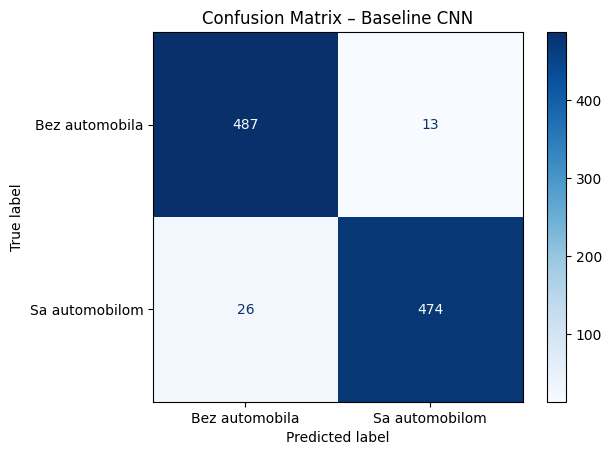

In [24]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Predikcije (0 ili 1)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Accuracy
acc = accuracy_score(y_test, y_pred)

# F1 score
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Bez automobila', 'Sa automobilom']
)

disp.plot(cmap='Blues')
plt.title("Confusion Matrix – Baseline CNN")
plt.show()


Baseline CNN model postiže visoku tačnost (Accuracy ≈ 96%), što ukazuje da je
model u velikoj meri sposoban da razlikuje slike koje sadrže automobile od onih
koje ih ne sadrže. Visoka vrednost F1 mere potvrđuje dobar balans između preciznosti
i odziva, što je posebno važno u uslovima potencijalne neravnoteže klasa.


# 6. Kratka diskusija

Model pokazuje sposobnost prepoznavanja osnovnih vizuelnih obrazaca koji
karakterišu prisustvo automobila na slici, poput kontura vozila, točkova i
kontrasta u odnosu na pozadinu. Visoka tačnost na trening i test skupu ukazuje
da je model uspešno naučio razliku između pozitivnih i negativnih primera.

Potencijalni problem predstavlja mogućnost preučenja (overfitting), što se
primećuje kroz veoma visoku trening tačnost u poređenju sa test rezultatima.
Takođe, iako binarna klasifikacija daje dobre rezultate, ovaj pristup ne pruža
informaciju o tačnoj lokaciji automobila na slici, što je ključno za zadatak
detekcije objekata.

Podaci su adekvatno pripremljeni za ovaj eksperiment: slike su normalizovane,
skalirane na jedinstvenu rezoluciju i balansirane korišćenjem osnovnih tehnika
augmentacije. Ovakva priprema je dovoljna za baseline model, ali za naredne
faze biće neophodno koristiti specijalizovane detekcione arhitekture poput YOLO-a.


# Kontrolna tačka 3 – Odabir algoritama i metrika uspešnosti, treniranje, validacija i testiranje + analiza rezultata

## 1. Uvod

Cilj treće kontrolne tačke je objediniti sve prethodne faze i pokazati sposobnost odabira, implementacije, treniranja i evaluacije modela za rešavanje problema detekcije automobila. Ova faza obuhvata:
- Odabir i obrazloženje algoritma
- Definisanje metrika uspešnosti
- Implementacija i treniranje modela
- Validacija i testiranje sa jasnom separacijom skupova
- Analiza rezultata i poređenje sa baseline modelom iz CP2

## 2. Odabir algoritma i obrazloženje


### 2.1 YOLO (You Only Look Once) - Odabrani algoritam

**YOLO v8** je odabran kao primarni algoritam za sledeće razloge:

1. **Brzina i efikasnost**: YOLO je pravi real-time detektor koji predviđa sva bounding box-ova odjednom, što ga čini znatno bržim od dvostepenih detektora poput RCNN.

2. **Prikladnost za jednostavne scenarije**: Budući da je naš dataset sadrži samo jednu klasu (automobil), YOLO je idealan izbor - nije potrebna kompleksnost višeklasne detekcije.

3. **Jednostavnost implementacije**: Korišćenje Ultralytics YOLOv8 biblioteke omogućava brzu implementaciju bez potrebe za detaljnom ručnom implementacijom arhitekture.

4. **Transfer learning**: Korišćenje pretreniranog modela na COCO datasetu omogućava bolju inicijalizaciju i brže konvergencije.

5. **Fleksibilnost**: YOLO pruža razne veličine modela (nano, small, medium, large, xlarge) što omogućava izbor između brzine i preciznosti.

**Alternativne arhitekture** koje bi bile pogodne:
- **SSD (Single Shot MultiBox Detector)**: Slična brzina kao YOLO
- **Faster RCNN**: Veća preciznost ali sporija
- **EfficientDet**: Dobar balans između brzine i preciznosti
- **UNet sa custom loss**: Za semantic segmentation pristup

Međutim, YOLO v8 je superioran za ovaj zadatak zbog svoje dokazane efikasnosti u produkcijskim okruženjima.


## 3. Definisanje metrika uspešnosti

Za problem detekcije automobila, koristiće se sledeće metrike:

### 3.1 Metrike za evaluaciju detekcije

1. **Intersection over Union (IoU)** - Osnovna metrika za detekciju
   - Meri overlap između predviđenog i stvarnog bounding boxa
   - IoU = Area(Predviđeno ∩ Stvarno) / Area(Predviđeno ∪ Stvarno)
   - Koristi se sa pragom 0.5 (IoU50) ili 0.75 (IoU75)

2. **Average Precision (AP)** - Osnovna metrika za YOLO
   - Prosečna preciznost kroz sve pragove pouzdanosti
   - AP50: prosečna preciznost sa IoU pragom 0.5
   - AP75: prosečna preciznost sa IoU pragom 0.75
   - AP50-95: prosečna preciznost sa IoU pragom od 0.5 do 0.95 (koristi se kao mAP)

3. **Precision** - Koliko predviđanja je ispravno
   - Precision = TP / (TP + FP)
   - Važno kako ne bi bilo lažnih alarma

4. **Recall** - Koliko je od stvarnih objekata pronađeno
   - Recall = TP / (TP + FN)
   - Važno kako ne bi bilo propuštenih automobila

5. **F1 Score** - Harmonijska sredina Precision i Recall
   - F1 = 2 × (Precision × Recall) / (Precision + Recall)

### 3.2 Tehnički parametri treniranja

- **Batch Size**: 16 (balans između memorije i stabilnosti gradijenta)
- **Learning Rate**: 0.001 sa scheduled decajem
- **Optimizer**: SGD sa momentum-om (default za YOLO)
- **Broj epoha**: 50-100
- **Loss funkcija**: YOLO loss (kombinacija lokalizacijske i klasifikacijske greške)


## 4. Priprema podataka u YOLO formatu


In [ ]:
# Instalacija YOLOv8 (Ultralytics)
!pip install -U ultralytics

print("YOLOv8 uspešno instaliran!")


In [ ]:
import os
import shutil
import yaml
from pathlib import Path

# Kreiraj direktorijumsku strukturu za YOLO
yolo_data_dir = os.path.join(data_dir, 'yolo_dataset')

# Obristi stari direktorijum ako postoji
if os.path.exists(yolo_data_dir):
    shutil.rmtree(yolo_data_dir)

# Kreiraj nove direktorijume
train_images_yolo = os.path.join(yolo_data_dir, 'images', 'train')
train_labels_yolo = os.path.join(yolo_data_dir, 'labels', 'train')
val_images_yolo = os.path.join(yolo_data_dir, 'images', 'val')
val_labels_yolo = os.path.join(yolo_data_dir, 'labels', 'val')

for dir_path in [train_images_yolo, train_labels_yolo, val_images_yolo, val_labels_yolo]:
    os.makedirs(dir_path, exist_ok=True)

print(f"YOLO direktorijumi kreirani u: {yolo_data_dir}")
print(f"Struktura:\n├── images/\n│   ├── train/\n│   └── val/\n└── labels/\n    ├── train/\n    └── val/")


In [ ]:
from sklearn.model_selection import train_test_split

# Odaberi 80% slika za treniranje, 20% za validaciju
all_images_list = list(all_images)
train_images_list, val_images_list = train_test_split(all_images_list, test_size=0.2, random_state=42)

print(f"Trening slika (originalne): {len(train_images_list)}")
print(f"Validacijske slike (originalne): {len(val_images_list)}")

# Kopiraj originalne slike i kreiraj label fajlove za trening set
for img_name in train_images_list:
    src_path = os.path.join(data_dir, 'data', 'training_images', img_name)
    dst_path = os.path.join(train_images_yolo, img_name)
    shutil.copy(src_path, dst_path)
    
    # Kreiraj YOLO label fajl
    label_name = img_name.rsplit('.', 1)[0] + '.txt'
    label_path = os.path.join(train_labels_yolo, label_name)
    
    # Pronađi sve bounding boxove za ovu sliku
    img_boxes = annotations[annotations['image'] == img_name]
    
    with open(label_path, 'w') as f:
        for _, row in img_boxes.iterrows():
            # YOLO format: <class_id> <x_center> <y_center> <width> <height> (normalizovano 0-1)
            # Pretpostavljamo da je slika 676x380
            img_width, img_height = 676, 380
            
            x_min, y_min, x_max, y_max = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            x_center = (x_min + x_max) / 2 / img_width
            y_center = (y_min + y_max) / 2 / img_height
            width = (x_max - x_min) / img_width
            height = (y_max - y_min) / img_height
            
            f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
    
    if len(img_boxes) == 0:
        # Ako slika nema automobila, kreiraj prazan label fajl
        with open(label_path, 'w') as f:
            pass

# Kopiraj validacijske slike i kreiraj label fajlove
for img_name in val_images_list:
    src_path = os.path.join(data_dir, 'data', 'training_images', img_name)
    dst_path = os.path.join(val_images_yolo, img_name)
    shutil.copy(src_path, dst_path)
    
    # Kreiraj YOLO label fajl
    label_name = img_name.rsplit('.', 1)[0] + '.txt'
    label_path = os.path.join(val_labels_yolo, label_name)
    
    # Pronađi sve bounding boxove za ovu sliku
    img_boxes = annotations[annotations['image'] == img_name]
    
    with open(label_path, 'w') as f:
        for _, row in img_boxes.iterrows():
            img_width, img_height = 676, 380
            
            x_min, y_min, x_max, y_max = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            x_center = (x_min + x_max) / 2 / img_width
            y_center = (y_min + y_max) / 2 / img_height
            width = (x_max - x_min) / img_width
            height = (y_max - y_min) / img_height
            
            f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
    
    if len(img_boxes) == 0:
        with open(label_path, 'w') as f:
            pass

print(f"✓ Slike kopirane i label fajlovi kreirani")
print(f"  - Train: {len(os.listdir(train_images_yolo))} slika")
print(f"  - Val: {len(os.listdir(val_images_yolo))} slika")
